In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [11]:
start_date = '2020-01-01'
end_date = '2022-12-31'
stock = ["GOOGL", "AAPL", "ORCL", "MSFT", "AMZN"]
data = yf.download(stock, start_date, end_date)["Close"]

[*********************100%***********************]  5 of 5 completed


In [24]:
class Result():
    def __init__(self, data, lag, ticker):
        self.data = data
        self.lag = lag
        self.ticker = ticker
        def positive_price(x):
            if x["return"] >0:
                return x[self.ticker]
            else:
                return 0        
        self.data["return"] = self.data[self.ticker].pct_change()
        self.data["positive_price"]=self.data.apply(positive_price, axis=1)  
        self.data["prob"]=(self.data["positive_price"].rolling(window=self.lag).sum())/(data[self.ticker].rolling(window=self.lag).sum())

    def get_return(self):
        sig = 1*(self.data["prob"]>0.6)-1*(self.data["prob"]<0.4)              
        r = (sig*self.data["return"][1:])
        return r
        
    def get_strategy_return(self):
        return np.prod(1+self.get_return())**(252/len(self.get_return()))-1

    def get_sharpe(self):
        r =self.get_return()
        try:
            return (self.get_strategy_return())/(np.std(r)*np.sqrt(252))
        except Exception:
            return 0      

    def get_summary(self):
        return pd.DataFrame({"return":[f"{round(self.get_strategy_return()*100,3)}%"], "sharpe":[f"{round(self.get_sharpe(),3)}"]})
        
    def get_plot(self):
        r =self.get_return()
        plt.plot(np.cumprod(1+r), label=f"strategy for {self.ticker}")
        # plt.plot(np.cumprod(1+self.data["return"]), label="buy and hold") 
        plt.title("Cumulative return") 
        plt.legend()   
  



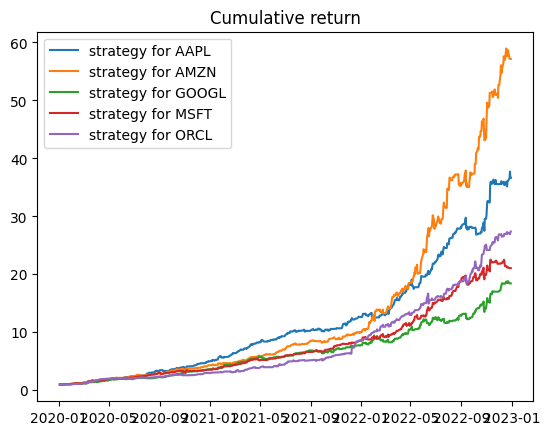

In [25]:
m = []
lag=5
for i in data.columns:
    m.append(Result(pd.DataFrame(data[i]),lag,i))

for i in m:
    i.get_plot()

In [23]:
for i in m:
    print(f"{i.ticker}\n{i.get_summary()}\n\n")

AAPL
     return sharpe
0  232.143%   8.87


AMZN
    return sharpe
0  285.23%  9.429


GOOGL
     return sharpe
0  164.162%  5.948


MSFT
     return sharpe
0  176.174%   7.06


ORCL
    return sharpe
0  201.44%   7.78


